In [1]:
import json
import matplotlib.pyplot as plt
import torch
import random
from typing import Union
from utils.customtypes import Circuit
from utils.plotter import drawCircuit
from sampler.randomcircuit import RandomCircuit
from sampler.circuitsampler import CircuitSampler

nq = 100

with open(f'../data/all_{nq}.json', 'r') as f:
    circ_data = json.load(f)['circuits']

In [2]:
def circ_flatten(slice_gates: list[tuple[tuple[int,int]]]) -> list[tuple[int,int]]:
    return sum(slice_gates, [])

def get_dist(gates: list[tuple[int,int]], nqs: int) -> torch.Tensor:
    counts = torch.zeros((nqs,))
    for (a,b) in gates:
        counts[a] += 1
        counts[b] += 1
    return counts/len(gates)

def entropy(dist: torch.Tensor) -> float:
    dist = torch.distributions.Categorical(probs=dist)
    return dist.entropy().item()


def get_per_window_dist(gates: list[tuple[int,int]], nqs: int, winsize: int, overlap: int) -> list[torch.Tensor]:
    dists = []
    for idx in range(0, len(gates) - winsize + 1, winsize - overlap):
        dists.append(get_dist(gates[idx:idx+winsize], nqs))
    return dists

Circuit has 4950 gates and 197 slices
4.605169773101807
N spectras is 101


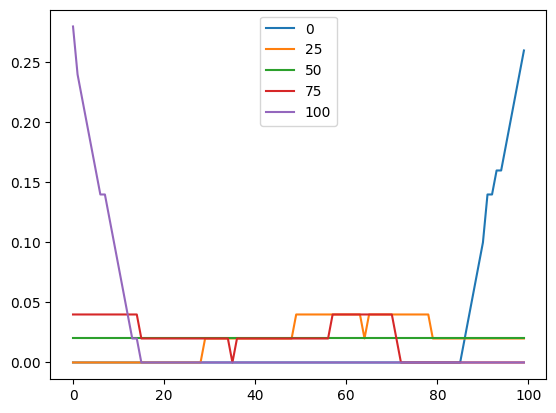

In [3]:
qft_sg = circ_data['qft']
qft_gates = circ_flatten(qft_sg)
print(f'Circuit has {len(qft_gates)} gates and {len(qft_sg)} slices')
spectra = get_dist(qft_gates, nq)
spectras = get_per_window_dist(
    gates=qft_gates,
    nqs=nq,
    winsize=50,
    overlap=1,
)
entropys = [entropy(d) for d in spectras]
print(entropy(spectra))
print(f'N spectras is {len(spectras)}')

# plt.plot(entropys)
each = 25
for i,d in enumerate(spectras[::each]):
    plt.plot(d, label=f'{i*each}')
plt.legend()

In [4]:
class StructuredRandomCircuit(CircuitSampler):

  def __init__(self, num_lq: int, slice_range: tuple[int,int], pattern_size: int, reflow: Union[bool,float] = False):
    super().__init__(num_lq)
    self.slice_range = slice_range
    self.pattern_size = pattern_size
    self.reflow = reflow


  def _new_qubit(self) -> int:
    # if not hasattr(self, 'lastq'):
    #   self.lastq = -1
    # self.lastq = (self.lastq + 1)%self.num_lq
    # return self.lastq
    return random.randint(0, self.num_lq-1)
  

  def _get_qubit(self, dist: torch.Tensor, prob_new: float, last_n: list[int], forbidden: list[int] = []) -> int:
    while True:
      # Get new qubit not in the sequence
      if torch.rand(1) < prob_new or dist.sum() == 0 or len(last_n) == 0:
        q = self._new_qubit()
        if q in last_n or q in forbidden:
          continue
        break
      # Repeat pattern
      else:
        idx = torch.distributions.Categorical(probs=dist/dist.sum()).sample().item()
        q = last_n[idx]
        if last_n[idx] in forbidden:
          continue
        break
    return q


  def _sample_gate(self):
    repeated = True
    while repeated:
      a = self._get_qubit(self.dist_a[-len(self.last_n_a):], self.prob_new_q_a, self.last_n_a)
      b = self._get_qubit(self.dist_b[-len(self.last_n_b):], self.prob_new_q_b, self.last_n_b, [a])
      repeated = self.last_gate is not None and self.last_gate in [(a,b), (b,a)]
    self.last_gate = (a,b)
    self.last_n_a.append(a)
    self.last_n_a = self.last_n_a[-self.pattern_size:]
    self.last_n_b.append(b)
    self.last_n_b = self.last_n_b[-self.pattern_size:]
    return (a,b)


  def _gen_prob_vec(self, smoothing: float, zero_last: bool):
    p = torch.randn(self.pattern_size).abs() + torch.linspace(self.pattern_size*smoothing,0,self.pattern_size)
    if zero_last:
      p[-1] = 0
    return p/p.sum()


  def sample(self) -> Circuit:
    self.lastq = -1
    self.last_n_a = []
    self.last_n_b = []
    self.prob_new_q_a = torch.rand(1).abs().item()*0.5 + 0.1
    self.prob_new_q_b = torch.rand(1).abs().item()*0.5 + 0.1
    smth = 0.5
    self.dist_a = self._gen_prob_vec(smoothing=smth, zero_last=False)
    self.dist_b = self._gen_prob_vec(smoothing=smth, zero_last=True)
    self.last_gate = None
    print(f"Prob new: {(self.prob_new_q_a,self.prob_new_q_b)}\nDist a: {self.dist_a}\nDist b: {self.dist_b}")

    int_num_slices = random.randint(a=self.slice_range[0], b=self.slice_range[1])
    circuit_slice_gates = []
    a,b = self._sample_gate()
    for t in range(int_num_slices):
      used_qubits = set()
      slice_gates = []
      while not (a in used_qubits or b in used_qubits):
        slice_gates.append((a,b))
        used_qubits.add(a)
        used_qubits.add(b)
        a,b = self._sample_gate()
      circuit_slice_gates.append(tuple(slice_gates))
    if (self.reflow if isinstance(self.reflow, bool) else (random.randint(0,100) < 100*self.reflow)):
      gate_list = sum(circuit_slice_gates, tuple())
      return Circuit.from_gate_list(gates=gate_list, n_qubits=self.num_lq)
    return Circuit(slice_gates=tuple(circuit_slice_gates), n_qubits=self.num_lq)
  

  def __str__(self):
    return (f"StructuredRandomCircuit("
                f"num_lq={self.num_lq}, "
                f"slice_range={self.slice_range}, "
                f"last_n={self.pattern_size})")

Prob new: (0.16465014815330506, 0.4750628530979156)
Dist a: tensor([0.4469, 0.2576, 0.1421, 0.1533])
Dist b: tensor([0.4087, 0.3479, 0.2434, 0.0000])


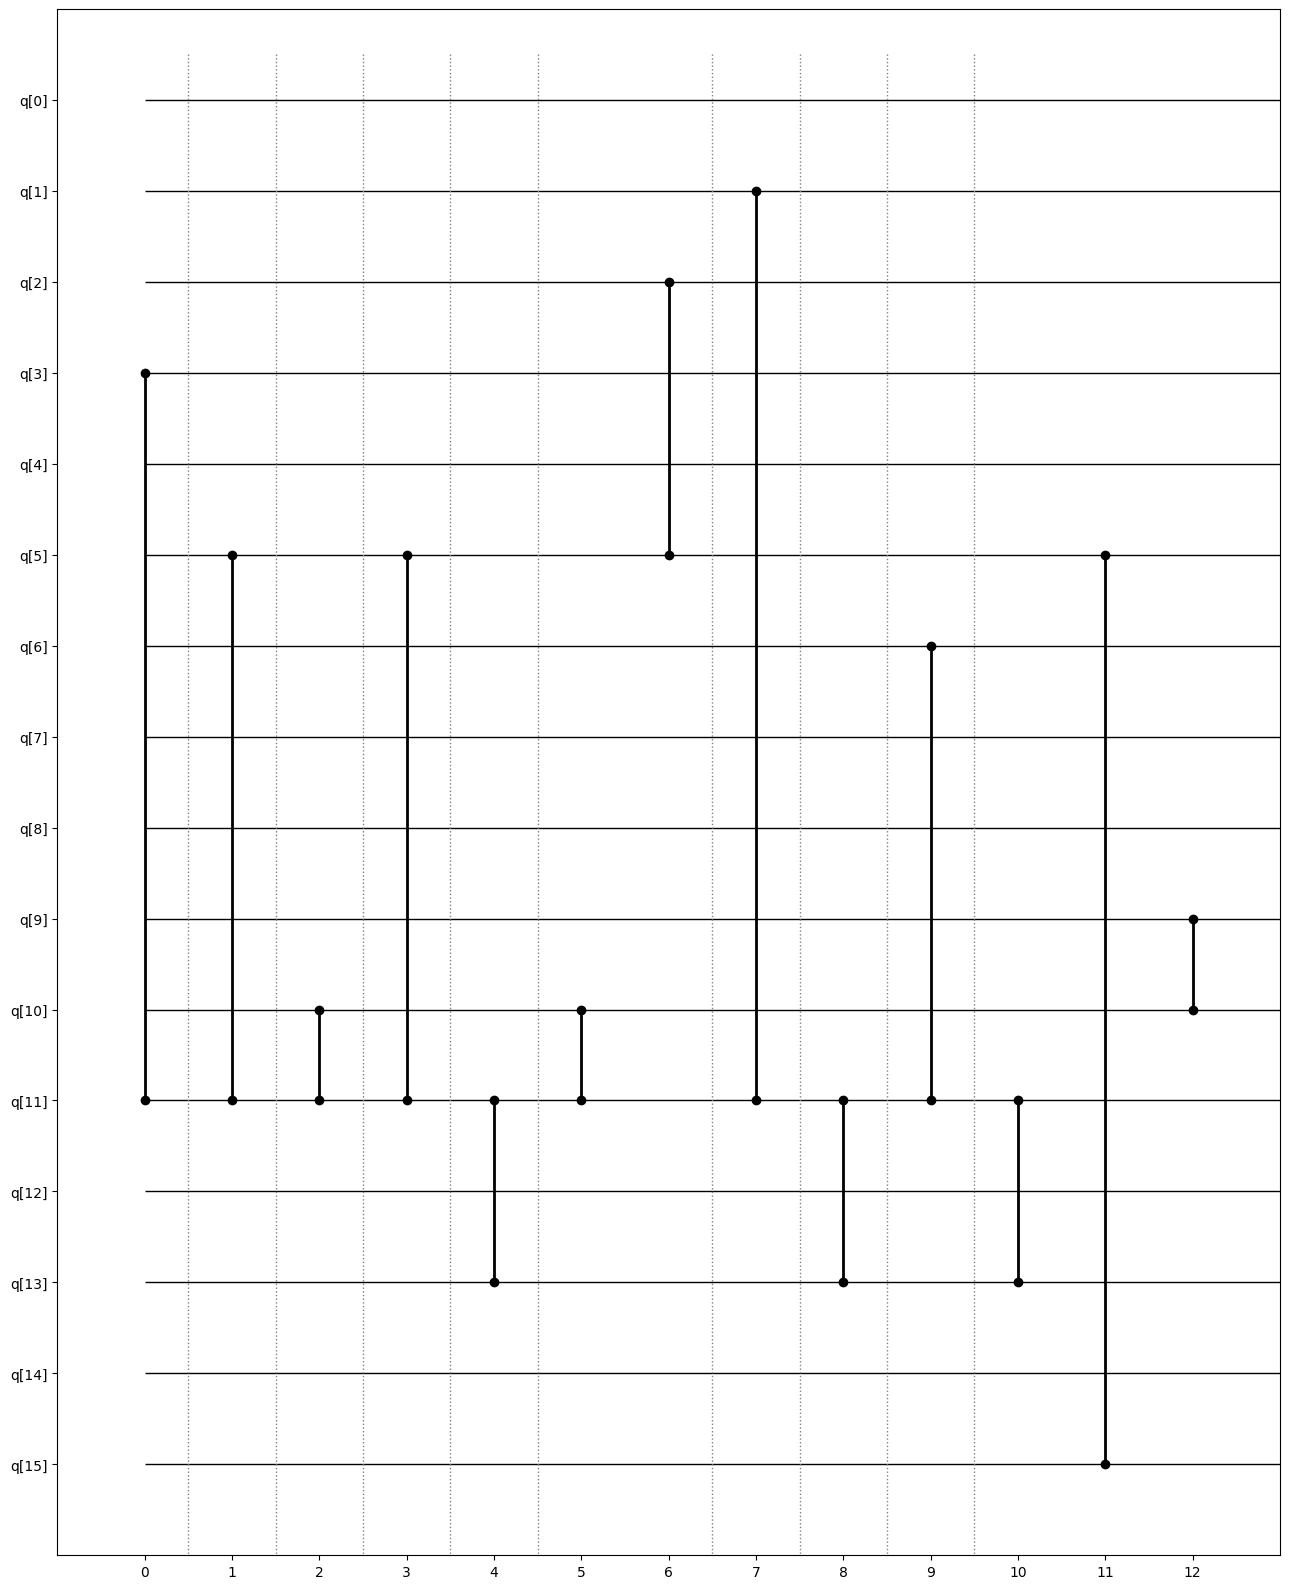

In [9]:
sampler = StructuredRandomCircuit(num_lq=16, slice_range=[8,16], pattern_size=4, reflow=False)

circuit = sampler.sample()
drawCircuit(circuit_slice_gates=circuit.slice_gates, num_lq=circuit.n_qubits)